In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  2404k      0  0:00:02  0:00:02 --:--:-- 2037k
Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
cd ml-100k/

In [ ]:
ls

In [ ]:
!head u.data
!echo # line break
!wc -l u.data

In [ ]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head(
)

In [ ]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

In [ ]:
#Now we can contruct the ratings matrix

ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

In [17]:
#Test for sparsity

sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


In [18]:
#Split the data for training and testing

def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [20]:
train, test = train_test_split(ratings)

 user- and item-based collaborative filtering. In either scenario, one builds a similarity matrix. For user-based collaborative filtering, the user-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.
A common distance metric is cosine similarity. The metric can be thought of geometrically if one treats a given user's (item's) row (column) of the ratings matrix as a vector. For user-based collaborative filtering, two users' similarity is measured as the cosine of the angle between the two users' vectors. For users ${u}$ and ${u'}$, the cosine similarity is

![Cosine SImilarity](https://blog.nycdatascience.com/wp-content/uploads/2017/01/eq1-300x77.png)

In [21]:
def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [22]:
%timeit similarity(train, kind='user')

26.2 ms ± 709 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
user_similarity = similarity(train, kind='user')
item_similarity = similarity(train, kind='item')
print (item_similarity[:4, :4])

[[ 1.          0.40205013  0.31885105  0.44134709]
 [ 0.40205013  1.          0.26861158  0.4861074 ]
 [ 0.31885105  0.26861158  1.          0.3258941 ]
 [ 0.44134709  0.4861074   0.3258941   1.        ]]


With our similarity matrix in hand, we can now predict the ratings that were not included with the data. Using these predictions, we can then compare them with the test data to attempt to validate the quality of our recommender model.

For user-based collaborative filtering, we predict that a user's $u$'s rating for item $i$ is given by the weighted sum of all other users' ratings for item $i$ where the weighting is the cosine similarity between the each user and the input user $u$. After Normalizing by the number of ${r_{u'i}}$ ratings 

![Cosine Predictions](https://blog.nycdatascience.com/wp-content/uploads/2017/01/eq3-300x88.png)

In [26]:
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [27]:
#We'll use the scikit-learn's mean squared error function as our validation metric

In [28]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [29]:
item_prediction = predict(train, item_similarity, kind='item')
user_prediction = predict(train, user_similarity, kind='user')

print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 8.50977007812
Item-based CF MSE: 11.5902246681


We can attempt to improve our prediction MSE by only considering the top $k$ users who are most similar to the input user (or, similarly, the top $k$ items). That is, when we calculate the sums over $u'$

In [35]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [36]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 6.55514002528
Top-k Item-based CF MSE: 7.76550133974


In [44]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  
    
print (str(user_test_mse))
print (str(item_test_mse))

[8.5399851395674666, 7.00370552158269, 6.6262895326175819, 6.5459679134975302, 6.6169043734276602, 6.9459044609625069]
[8.375459659592611, 7.5243904576839515, 7.6165241953021354, 7.9027785557676191, 8.5292793299352212, 9.3418570238756455]


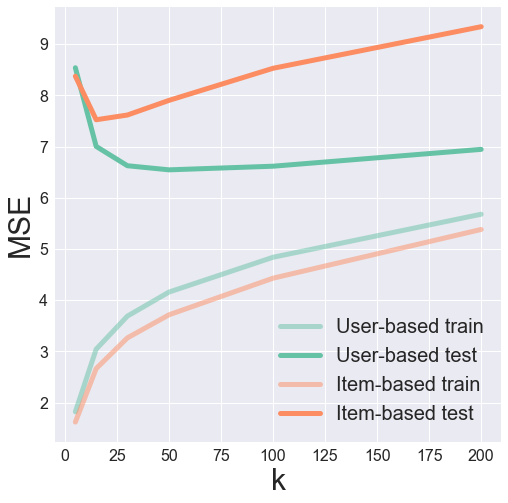

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [49]:
import requests
import json

response = requests.get('http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)')
print (response.url.split('/')[-2])

www.imdb.com


In [1]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
headers = {'Accept': 'application/json'}
payload = {'api_key': '29c5f17b003f03b1d828aef23f3fc2e5'} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url):
    # Get IMDB movie ID
    response = requests.get(imdb_url)
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': '29c5f17b003f03b1d828aef23f3fc2e5'} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie', params=payload, headers=headers)
        movie_id = json.loads(response.text)['results'][0]['id']
        payload.pop('query', None)
        movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
        response = requests.get(movie_url, params=payload, headers=headers)
        file_path = json.loads(response.text)['posters'][0]['file_path']
        
    return base_url + file_path

NameError: name 'requests' is not defined

In [55]:
from IPython.display import Image
from IPython.display import display

toy_story = 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)'
Image(url=get_poster(toy_story, base_url))

IndexError: list index out of range

In [56]:
# #We can build a dictionary to map the movie-indices from our
# similarity matrix to the urls of the movies. We'll also create
# a helper function to return the top-k most similar movies given some 
# input movie.

In [58]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r', encoding = "ISO-8859-1") as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [59]:
idx = 0 # Toy Story
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)

IndexError: list index out of range

In [60]:
idx = 20 # Muppet Treasure Island
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

IndexError: list index out of range